The complete explanation for this notebook is available at https://youranalystbuddy.com/logistic-regression/

## Logistic Regression

### Data introduction

In this example, we use the heart disease data. You can find the dataset in https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction. The data has the following features

1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality, LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

The target is HeartDisease

### Loading data

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('heart_disease.csv')
data.head(n=2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


#### Train/Test Split 

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2)

<h4>Preliminary Analysis</h4>

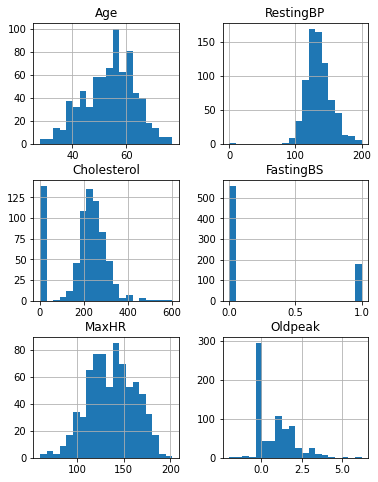

In [4]:
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

import matplotlib.pyplot as plt
trainX.hist(figsize=(6,8), bins=20)
plt.show()

Sex


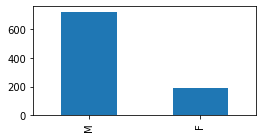

ChestPainType


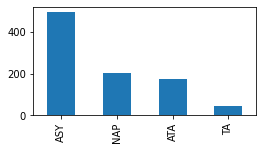

RestingECG


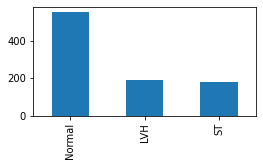

ExerciseAngina


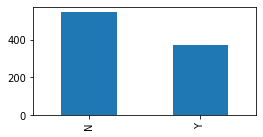

ST_Slope


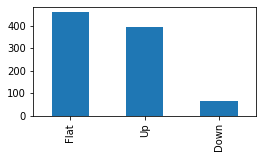

In [5]:
cat_cols = ['Sex', 'ChestPainType','RestingECG', 'ExerciseAngina', 'ST_Slope']

for col in cat_cols:
    print(col)
    data[col].value_counts().plot(kind='bar', figsize=(4,2))
    plt.show()

The only issue is some rows have Cholesterol and RestingBP of 0. We will consider these missing and impute them.

#### Preprocessing

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def remove_0(X):
    X.loc[X['Cholesterol']==0, 'Cholesterol'] = np.nan
    X.loc[X['RestingBP']==0, 'RestingBP'] = np.nan
    return X

num_pipeline = Pipeline([
    ('remove 0', FunctionTransformer(remove_0, validate=False)),
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant',fill_value='missing')),
    ('encode', OneHotEncoder())
])

full_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, num_cols),
    ('class', cat_pipeline, cat_cols)
])

trainX_prc = full_pipeline.fit_transform(trainX)
testX_prc = full_pipeline.transform(testX)  

### Modeling

#### L2 Regularization

Recall, this is similar to Ridge regression - we add the sum of squares values of coefficients to the training objective. However, the hyperparameter is <b>C</b>, NOT alpha.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = [{'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1 , 5, 10, 50, 100]}]

#the default is l2 anyway, but we can specify it so that the code is clear
#logistic regression is also trained iteratively, we can increase max_iter if you see some warning from sklearn
logistic = LogisticRegression(penalty='l2', max_iter=5000)

grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy', return_train_score=True)

grid_search.fit(trainX_prc,trainY)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000),
             param_grid=[{'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,
                                50, 100]}],
             return_train_score=True, scoring='accuracy')

Let's look at the best model

In [8]:
print(grid_search.best_params_)
print(grid_search.best_score_) #accuracy

{'C': 0.05}
0.8556425309849967


And apply it on the testing data

In [9]:
grid_search.score(testX_prc, testY) #accuracy

0.8804347826086957

<h4>L1 Regularization</h4>

This is similar to LASSO, we add sum of absolute values to the training objective

In [10]:
param_grid = [{'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1 , 5, 10, 50, 100]}]

#now we need to specify penalty to l1
#also, we need to set solver to 'liblinear' because the default solver doesn't support l1
logistic = LogisticRegression(penalty='l1', max_iter=5000, solver='liblinear')

grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy', return_train_score=True)

grid_search.fit(trainX_prc,trainY)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=5000, penalty='l1',
                                          solver='liblinear'),
             param_grid=[{'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,
                                50, 100]}],
             return_train_score=True, scoring='accuracy')

Best model performance:

In [11]:
print(grid_search.best_params_)
print(grid_search.best_score_) #accuracy

{'C': 0.1}
0.859742801230081


And in the testing data

In [12]:
grid_search.score(testX_prc, testY) #accuracy

0.8586956521739131

<h4>Elastic Net Regularization</h4>

Similar to Elastic Net model in regression, we use both l1 and l2 regularization in the same model. Now we need to finetune both C and l1_ratio

In [13]:
#now penalty is changed to elasticnet
#and we need to change solver to saga
logistic = LogisticRegression(penalty='elasticnet', max_iter=5000, solver='saga')

param_grid = [{
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1 , 5, 10, 50, 100],
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}]

grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy', return_train_score=True)

grid_search.fit(trainX_prc,trainY)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=5000, penalty='elasticnet',
                                          solver='saga'),
             param_grid=[{'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,
                                50, 100],
                          'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                       0.9]}],
             return_train_score=True, scoring='accuracy')

Best model performance

In [14]:
print(grid_search.best_params_)
print(grid_search.best_score_) #accuracy

{'C': 0.05, 'l1_ratio': 0.4}
0.8624452520734321


And apply to testing data

In [15]:
grid_search.score(testX_prc, testY)

0.8586956521739131